In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/philippe/MolGenDocking


/home/philippe/miniconda3/envs/MolGen/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import json
import pandas as pd
from mol_gen_docking.data.pdb_uniprot.target_naming import fetch_uniprot_id_from_pdbid
from tqdm import tqdm
from multiprocessing import Pool
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

# Prompts

In [ ]:
from mol_gen_docking.data.pydantic_dataset import read_jsonl
from pathlib import Path

def load(path:str):
    data = read_jsonl(Path(path))
    return [line.conversations[0].meta for line in data]

def get_df(data_d):
    df = pd.DataFrame(data_d)
    df= df.explode(["properties", "objectives", "target", "smiles"]).reset_index(drop=True)
    df["origin"] = df["properties"].apply(lambda x: x.split("/")[0])
    df["task"] = df["properties"].apply(lambda x: x.split("/")[1])
    return df

data_dir = "data/polaris"
types = ["novartis", "polaris", "tdcommons", "asap-discovery", "biogen"]


data = []
for d in types:
    directory = Path(os.path.join(data_dir, d))
    for file_path in directory.rglob('*train.jsonl'):
        data.append(get_df(load(file_path)))
        data[-1]["dataset"] ="/".join(str(file_path).split("/")[3:-1])

df = pd.concat(data)
df

In [ ]:
df.groupby("objectives").properties.count() / df.groupby("objectives").properties.count().sum()

In [4]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

mols = [Chem.MolFromSmiles(smi) for smi in tqdm(df.smiles.unique())]
scaffolds_list = [MurckoScaffold.GetScaffoldForMol(mol) for mol in tqdm(mols)]


 54%|█████▍    | 20897/38491 [00:01<00:01, 15819.26it/s]

KeyboardInterrupt: 

In [ ]:

scaffolds = {}
for smi, scaff in zip(df.smiles.unique(), tqdm(scaffolds_list)):
    if scaff.GetNumAtoms() <= 6:
        scaffolds[smi] = "n/a"
    else:
        scaffolds[smi] = Chem.MolToSmiles(scaff)
df["scaffold"] = df.smiles.map(scaffolds)

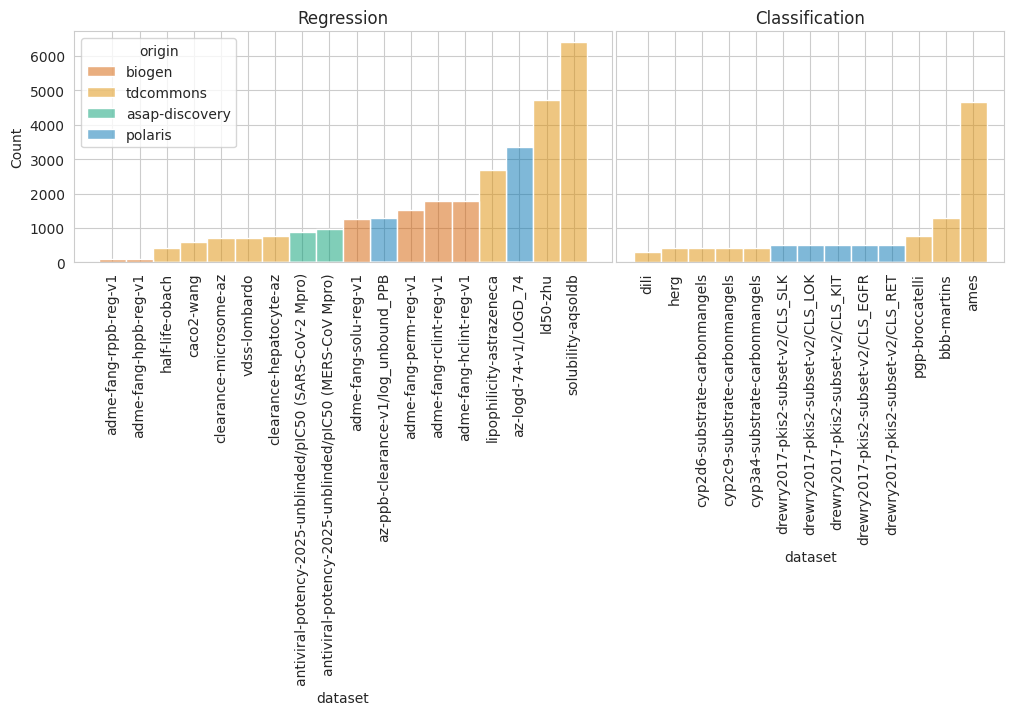

In [5]:
size = df.groupby("dataset").size().sort_values(ascending=False)
df["task size"] =df.dataset.map(size.to_dict())
palette = {
    origin: sns.color_palette("colorblind", n_colors=10)[i] for i,origin in enumerate(df.origin.unique())
}


fig, axes = plt.subplots(1,2,figsize = (12,3), gridspec_kw = {
    'width_ratios':[df[df.objectives == "regression"].dataset.nunique()/df.dataset.nunique(), df[df.objectives == "classification"].dataset.nunique()/df.dataset.nunique()],
}, sharey=True)
fig.subplots_adjust(wspace=0.01)
sns.histplot(df[df.objectives == "regression"].sort_values("task size"), x="dataset", hue="origin",ax = axes[0], palette=palette)
axes[0].set_title("Regression")
sns.histplot(df[df.objectives == "classification"].sort_values("task size"), x="dataset", hue="origin",ax = axes[1], palette=palette, legend=False)
axes[1].set_title("Classification")
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.savefig("mol_prop_task_size.pdf", bbox_inches="tight")

In [ ]:
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig, ax = plt.subplots(figsize=(14, 3))

count = df[df.scaffold.apply(len)>3].groupby("scaffold").size().sort_values(ascending=False)
scaffs_to_keep = count.index.tolist()[:30]


df["n_scaff"] = df.scaffold.map(count.to_dict())
df_top = df[df.scaffold.isin(scaffs_to_keep)]
df_top = df_top.sort_values("n_scaff", ascending=False)
sns.histplot(df_top, x="scaffold", hue="origin",multiple="stack", log_scale=False, ax=ax)
ax.set_xlabel("")
ax.set_xlim(-0.5,29.5)
ax.set_xticks([])  # remove default labels

scaff_to_img = {}
for scaff in scaffs_to_keep:
    mol = Chem.MolFromSmiles(scaff)
    if mol:
        img = Draw.MolToImage(mol, size=(80, 80))
        scaff_to_img[scaff] = img

# Add images as tick labels
for i, scaff in enumerate(scaffs_to_keep):
    if scaff in scaff_to_img:
        imagebox = OffsetImage(scaff_to_img[scaff], zoom = 0.2)
        ab = AnnotationBbox(imagebox, (i, 0), frameon=True, box_alignment=(0.5, 1.4))
        ax.add_artist(ab)


fig.savefig("mol_prop_scaff.pdf", bbox_inches="tight")

In [ ]:
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import DataStructs
from rdkit import RDLogger

RDLogger.DisableLog("rdApp.*")

def get_tanimoto_dist_between_datasets(df, dataset0, dataset1,radius=2, n_bits=1024, agg_fns = [np.mean]):
    mols = [
        [Chem.MolFromSmiles(smi) for smi in df[df.dataset == dataset0].smiles.unique()],
        [Chem.MolFromSmiles(smi) for smi in df[df.dataset == dataset1].smiles.unique()]
    ]
    fps_ = [
        [GetMorganFingerprintAsBitVect(m, radius, nBits=n_bits) for m in mol if m is not None]
        for mol in mols
    ]
    sims = np.zeros((len(fps_[0]), len(fps_[1])))
    for i,fp0 in enumerate(fps_[0]):
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fp0, fps_[1])
    output = [(np.mean(agg_fn(sims))+ np.mean(agg_fn(sims.transpose())))/2 for agg_fn in agg_fns]
    return output


In [ ]:
df_simi = []
pbar = tqdm(total=df.dataset.nunique()*(df.dataset.nunique()+1)//2)
agg_fns = [
    lambda arr: np.max(arr, axis=1),
    lambda arr: np.quantile(arr,0.99, axis=1),
    lambda arr: np.quantile(arr,0.9, axis=1),
    lambda arr: (arr>=0.6).mean(axis=1),
    lambda arr: (arr>=0.7).mean(axis=1),
    lambda arr: (arr>=0.8).mean(axis=1),
]
agg_fns_name = [
    "max",
    "99% quantile",
    "90% quantile",
    "Prop. over 0.6",
    "Prop. over 0.7",
    "Prop. over 0.8",
]

for i, dataset0 in enumerate(df.dataset.unique()):
    for dataset1 in df.dataset.unique()[i:]:
        sims_l = get_tanimoto_dist_between_datasets(df, dataset0, dataset1, agg_fns=agg_fns)
        for sims, name in zip(sims_l, agg_fns_name):
            df_simi.append([dataset0, dataset1, sims, name])
            df_simi.append([dataset1, dataset0, sims, name])
        pbar.update(1)
pbar.close()

df_simi = pd.DataFrame(df_simi, columns=["dataset0", "dataset1", "value", "agg_fn_name"])

In [ ]:
df_simi

In [ ]:
from scipy.cluster.hierarchy import linkage
for agg_name in agg_fns_name:
    data = df_simi[df_simi.agg_fn_name == agg_name].pivot_table(values="value", columns="dataset0", index="dataset1")
    row_linkage = linkage(data, method='ward')

    cg = sns.clustermap(data, row_linkage=row_linkage, col_linkage=row_linkage, figsize=(6,6))
    plt.title(f"agg_fn_name = {agg_name}")

    cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
    cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram
    plt.show()


In [ ]:
agg_name = "max"
data = df_simi[df_simi.agg_fn_name == agg_name].pivot_table(values="value", columns="dataset0", index="dataset1")
row_linkage = linkage(data, method='ward')

cg = sns.clustermap(data, row_linkage=row_linkage, col_linkage=row_linkage, vmax = 1,cbar_pos=(0.05, 0.3, 0.055, 0.5))


cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram

cg.savefig("tanimoto_mol_prop.pdf", bbox_inches="tight")